# Sine Wave

Based on exponential sine wave example 

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
np.random.seed(916301)

In [2]:
import dynesty

In [3]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'font.size': 15})

We first generate a simple transformed periodic single from $0$ to $2\pi$ based on the relation:

$$ y(x) = n_a \sin(f_a x + p_a)  $$

This has six free parameters controling the relevant amplitude, period, and phase of each component. We also have a seventh, $\sigma$, corresponding to the amount of scatter.

-0.6020599913279624 -1.8038801229698473 -0.3010299956639812


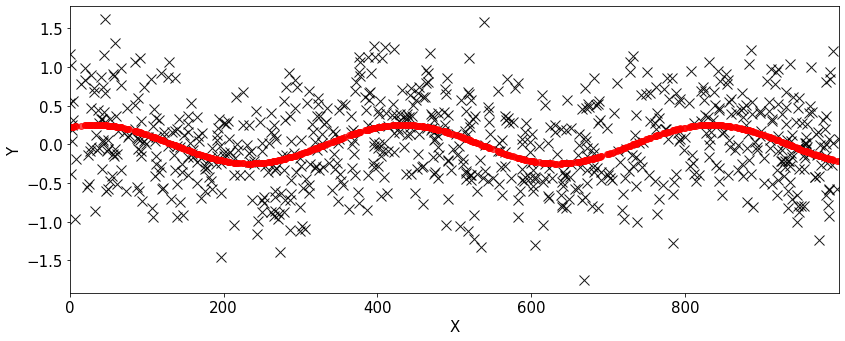

In [4]:
# x values sampled uniformly
x = np.random.uniform(0, 1000.0, size=800)
x.sort()

# define model
na = 0.25  # Amplitude
fa = 2.0*np.pi/400.0  # Frequency 
pa = 2.0*np.pi/6.0    # Phase
sigma = 0.5           # Add noise (white)

print(np.log10(na),np.log10(fa),np.log10(sigma))

# generate noisy observations
ypred = na * np.sin(x * fa + pa) 
y = np.random.normal(ypred, sigma)

# plot results
plt.figure(figsize=(12, 5))
plt.plot(x, y, color='black', marker='x', 
         ls='none', alpha=0.9, markersize=10)
plt.plot(x, ypred, marker='o', color='red', ls='none', alpha=0.7)
plt.xlim([-0.1, np.max(x) + 0.1])
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()

Our priors will be uniform in all dimensions, with the phases having periodic boundary conditions.

In [5]:
def prior_transform(u):
    # these are priors in log10 units (based on uniform random deviate from 0 to 1) except for phase
    v = u * 100
    v[0] = (u[0]-0.5) * 4 - 0.6
    v[1] = (u[1]-0.5) * 4 - 1.8
    v[2] = (u[2] % 1.) * 2 * np.pi
    v[3] = (u[3]-0.5) * 2 - 0.3
    return v

def loglike(v):
    logna, logfa, pa, logsigma = v   # non-periodic parameters are passed as log10(param)
    na, fa, pa, sigma = (10**logna, 10**logfa, pa, 10**logsigma)
    ypred = na * np.sin(x * fa + pa)
    residsq = (ypred  - y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [6]:
# sample
sampler = dynesty.NestedSampler(loglike, prior_transform, 4, 
                                periodic=[2],
                                sample='slice', nlive=250)
sampler.run_nested(dlogz=0.01)
res = sampler.results

5279it [00:41, 127.77it/s, +250 | bound: 108 | nc: 1 | ncall: 474239 | eff(%):  1.166 | loglstar:   -inf < -591.044 <    inf | logz: -607.508 +/-  0.339 | dlogz:  0.000 >  0.010]


In [7]:
from dynesty import utils as dyfunc

# compute ln(evidence) error
lnzs = np.zeros((100, len(res.logvol)))
for i in range(100):
    res_s = dyfunc.simulate_run(res)
    lnzs[i] = np.interp(-res.logvol, -res_s.logvol, res_s.logz)
lnzerr = np.std(lnzs, axis=0)
res.logzerr = lnzerr

Let's see how we did.

/Users/adamboesky/opt/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:287: RuntimeWarning: overflow encountered in exp
  for s in range(1, 4)]


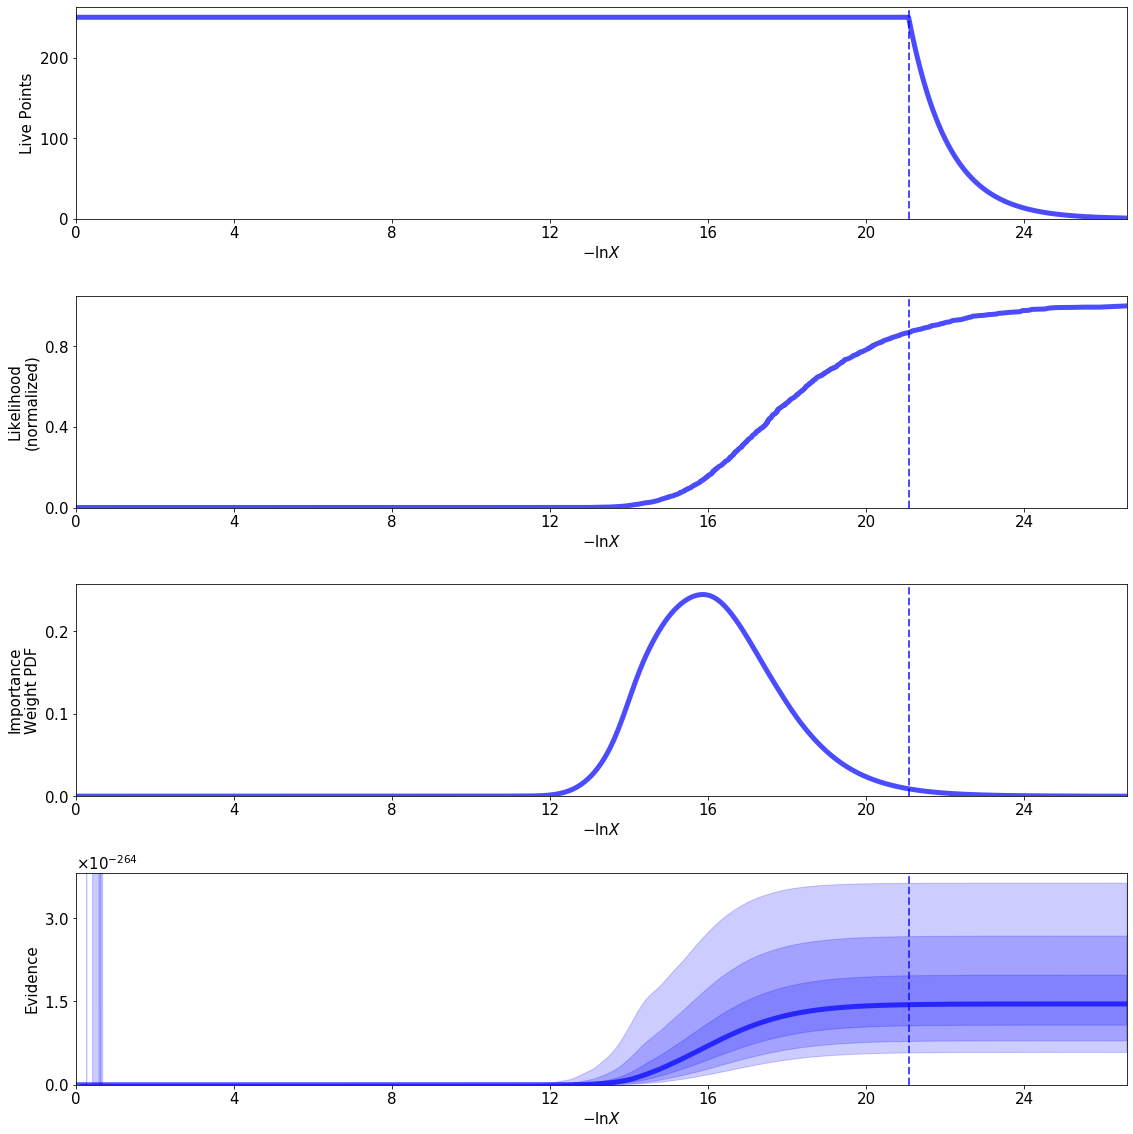

In [8]:
from dynesty import plotting as dyplot

dyplot.runplot(res)
plt.tight_layout()

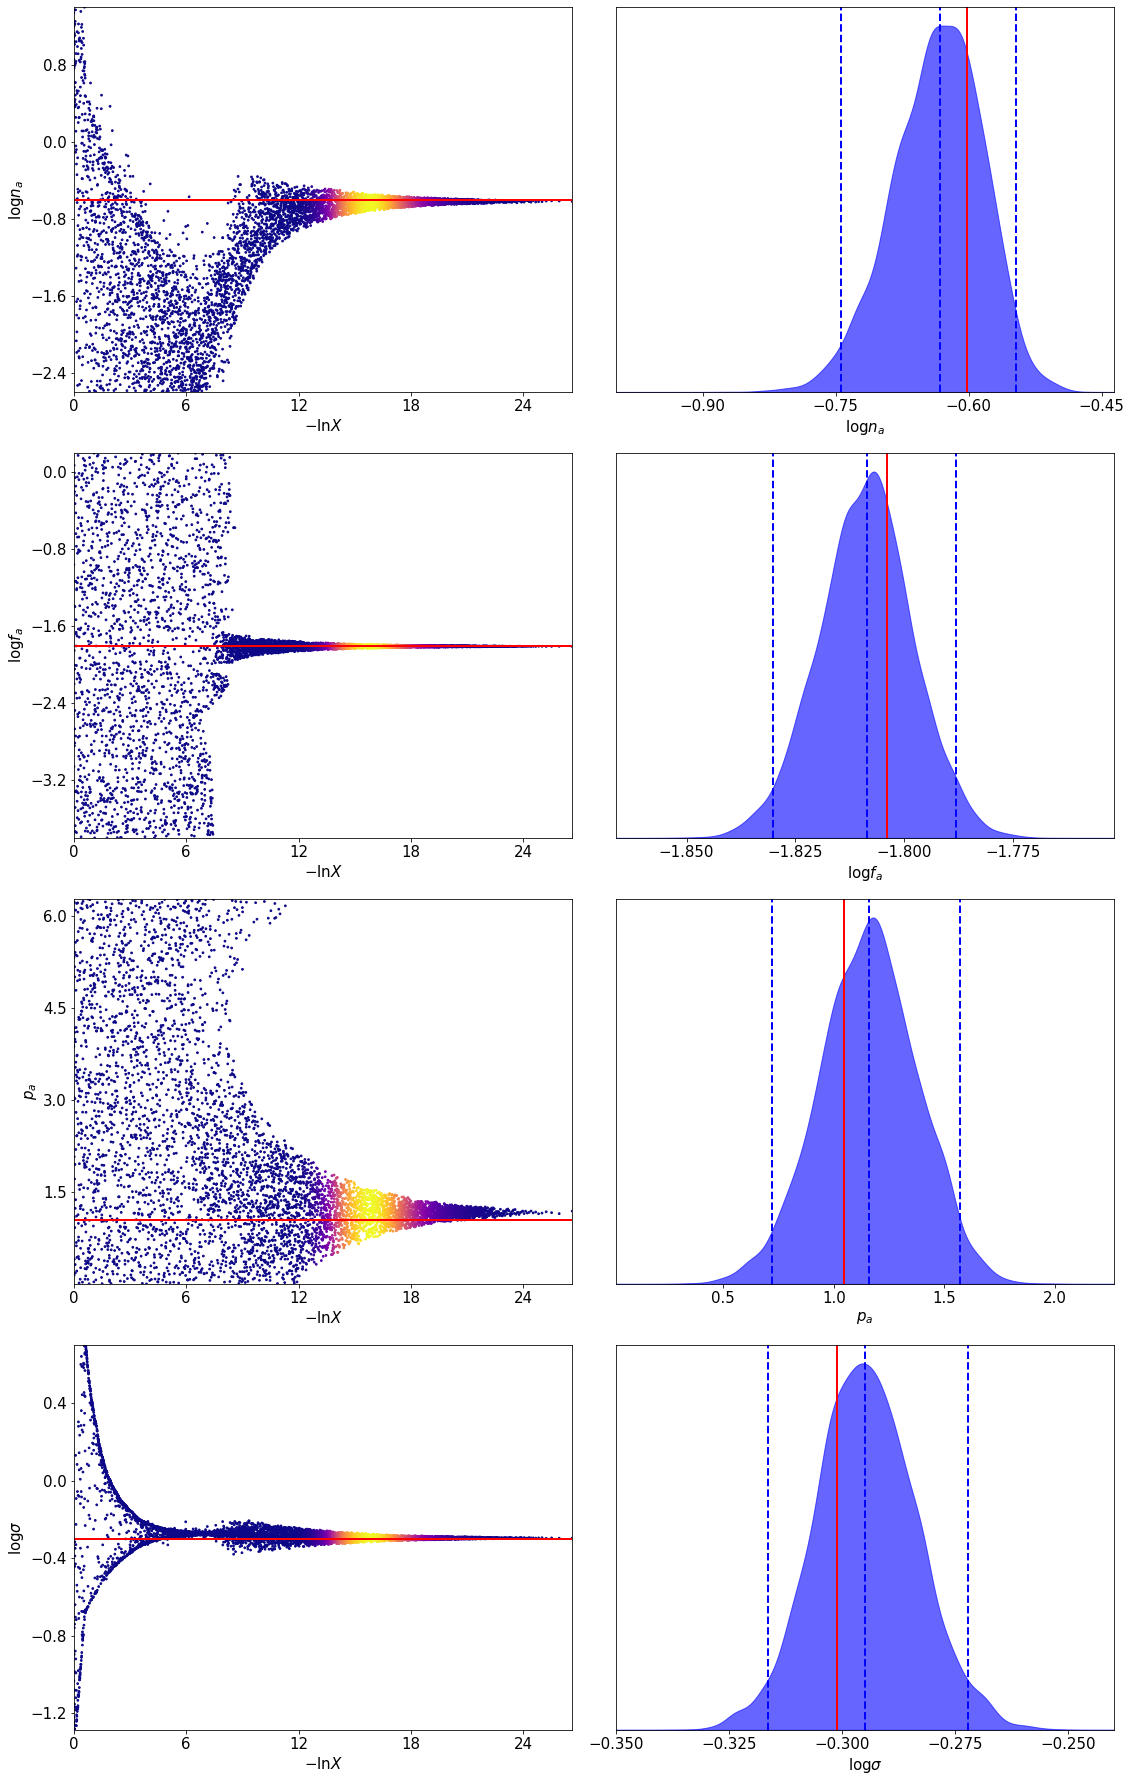

In [9]:
labels = [r'$\log n_a$', r'$\log f_a$', r'$p_a$', 
          r'$\log \sigma$']
truths = [np.log10(na), np.log10(fa), pa,
          np.log10(sigma)]
fig, axes = dyplot.traceplot(res, labels=labels, truths=truths,
                             fig=plt.subplots(4, 2, figsize=(16, 25)))
fig.tight_layout()

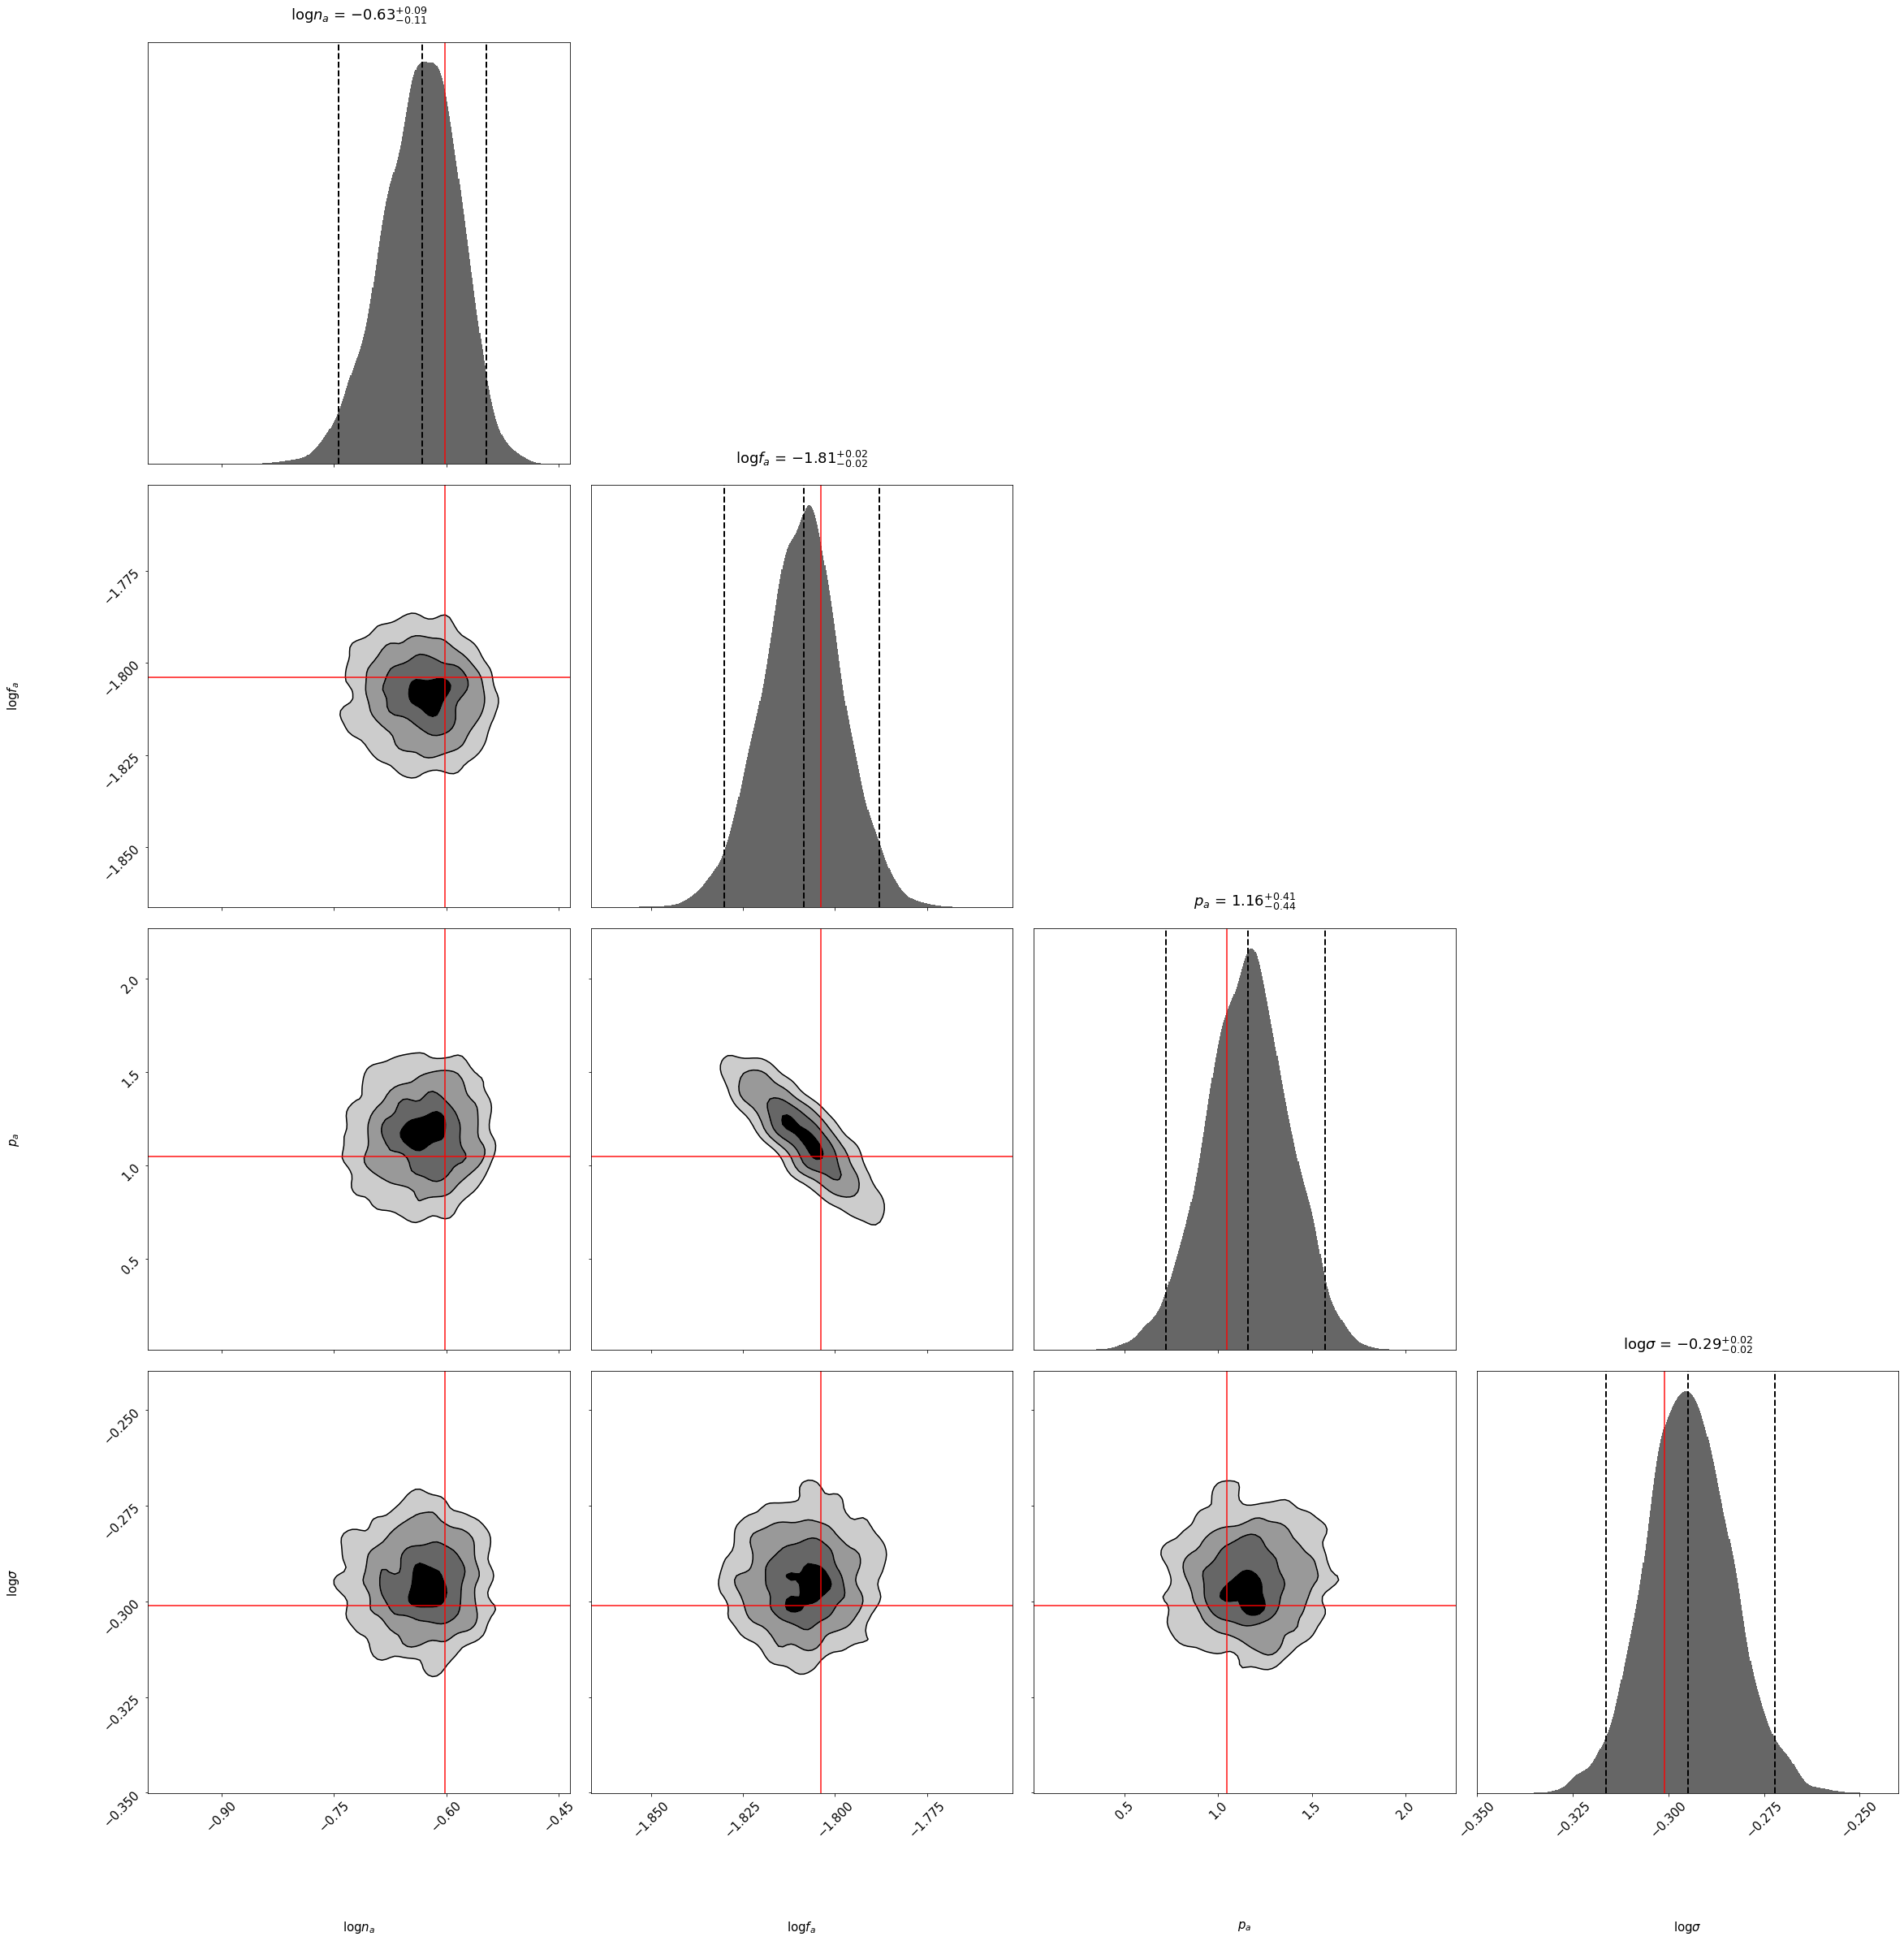

In [10]:
fig, axes = dyplot.cornerplot(res, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(4, 4, figsize=(35, 35)))

In [14]:
print(res.logz[-1])
for logz in res.logz:
    print(logz)

-607.5075144168245
-16472702.736423898
-13908362.842199922
-5945310.026578877
-4277260.988636643
-2648987.8699515453
-2592133.0210071676
-1323045.2337440473
-1184464.7335123338
-1135916.3861621085
-915487.6405819359
-638200.0839927887
-518151.75553437124
-512589.7527871567
-279897.4409430693
-254559.67598169495
-206377.94512861982
-177979.35772337727
-151550.31865991518
-146605.46778429757
-140733.01630160175
-127848.7022268997
-82544.37611788014
-65176.79247878033
-63649.38401892659
-55551.63914819251
-54338.94370587355
-48387.82369956982
-46149.3057926511
-43521.14594494441
-40232.04893674507
-39686.51015545595
-37052.807015742204
-36914.45740180049
-36782.9707885222
-36631.77124590216
-36246.97338024008
-36179.772448726544
-32916.03289599356
-32002.544221172517
-31782.892568364943
-31760.505713308365
-30505.86641213646
-29098.717228607195
-28509.547108837123
-26870.555952016304
-26767.80576995974
-26212.02419201819
-26112.193652123606
-25206.84987048669
-24742.632922043158
-24536.50

-638.5706094548079
-638.569084598751
-638.5675669686804
-638.5660560778574
-638.5645518265173
-638.5630541017108
-638.5615624074055
-638.5600769459616
-638.5585986777542
-638.5571267443942
-638.5556610000503
-638.5542009355125
-638.552745896696
-638.5512940995875
-638.5498458794373
-638.54840485242
-638.546971082928
-638.5455425179473
-638.544118792322
-638.5427015819234
-638.5412911904758
-638.5398819196708
-638.538473228644
-638.5370700744126
-638.5356725845709
-638.534281453726
-638.5328939426171
-638.5315104233522
-638.5301337238183
-638.5287636247197
-638.5273995885568
-638.5260412573152
-638.5246855280327
-638.5233320395
-638.52198445895
-638.5206429757831
-638.5193074170344
-638.51797825089
-638.5166551655575
-638.5153378229037
-638.5140268736141
-638.5127202899139
-638.5114174299516
-638.5101204818471
-638.5088280245122
-638.5075399386582
-638.506257998503
-638.5049818861806
-638.5037087909794
-638.5024389301874
-638.5011740486487
-638.499911473847
-638.4986505905214
-638.49739

-613.3374895307426
-613.3244148942706
-613.3109898782203
-613.2974380559292
-613.2838067661665
-613.2701592572395
-613.2565238008515
-613.2429324982616
-613.2294758727014
-613.2161489936838
-613.2029894083412
-613.1899615761935
-613.1769829359258
-613.1641121746745
-613.1514488077421
-613.138906609754
-613.126377817723
-613.1137359174672
-613.1010828879972
-613.0885365302544
-613.0759870784283
-613.0634975570539
-613.051089940339
-613.0386668644114
-613.0263195038211
-613.013986812477
-613.0016470948592
-612.9892404501388
-612.9767222370408
-612.9643313572659
-612.9520429767826
-612.9397848170006
-612.927565332512
-612.9153911920262
-612.9032389312655
-612.8911220455512
-612.879129599946
-612.8671761703749
-612.8552223609862
-612.8433862648919
-612.83165610503
-612.8199941199789
-612.8084531295636
-612.7970772052302
-612.7856520717509
-612.7741592307198
-612.7627333488083
-612.7513466688945
-612.7400820936248
-612.7289787228705
-612.7179758281046
-612.7070104317363
-612.6961258559671
-

-607.5898679594687
-607.5895744078532
-607.5892819121681
-607.5889905841636
-607.5887003966556
-607.5884114071358
-607.5881234650864
-607.5878361000324
-607.587549331383
-607.5872632236432
-607.5869777397062
-607.5866930782287
-607.5864092940275
-607.5861264355299
-607.5858445415627
-607.5855637288722
-607.5852840592983
-607.5850052892878
-607.5847273496546
-607.5844503934063
-607.5841744924046
-607.5838995387518
-607.583625312551
-607.5833519593039
-607.5830796943189
-607.5828084891938
-607.5825383354811
-607.5822692934564
-607.582001291543
-607.5817343349976
-607.5814685039392
-607.5812037629977
-607.580940025646
-607.5806773136277
-607.5804156781788
-607.5801550983066
-607.5798954065181
-607.5796365431406
-607.5793786070799
-607.5791214508303
-607.5788651119784
-607.5786096895114
-607.5783552228402
-607.5781017837941
-607.5778493617731
-607.5775979801751
-607.5773476219384
-607.5770980336363
-607.5768492259712
-607.576601252231
-607.576353961249
-607.5761075002615
-607.5758619594756